In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
pd.options.mode.chained_assignment = None

%matplotlib inline

In [46]:
#Uploading the dataset
dataset=pd.read_csv('./lalonde.csv')

#Filtering treated and untreated subjects into two separate dataframe for later use.
treated=dataset[dataset['treat']==1]
untreated=dataset[dataset['treat']==0]

# I. Propensity score matching : 

## 1.a Summaries:

In [47]:
#datasets containing outcomes
treated_outcome=treated['re78']
untreated_outcome=untreated['re78']

In [48]:
#Printing summary of the treated subjects
treated_outcome.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [49]:
#Printing summary of the treated subjects
untreated_outcome.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

From the two summaries, we might conclude that the effect of the treatement is negligeable. The means are very close, and so are the standard deviations. 

One might even conclude that the control group has better results since its mean as well as its median are higher than those of the treated group, but it is not significant enough.

In conclusion, a naive researcher will conclude that the training had no effect whatsoever on the subject, so it is better not to spend the money and time on it.

## Plot of the summary : 

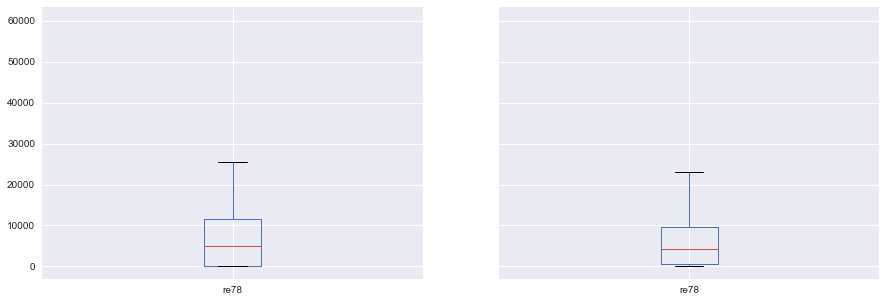

In [50]:
#Printing the summaries in boxplots.
f, ax = plt.subplots(1, 2, sharex=True,sharey=True,figsize=(15, 5))
untreated_outcome.plot(ax=ax[0],kind='box')
treated_outcome.plot(ax=ax[1],kind='box')
plt.show()

## 1.b Plots : 

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


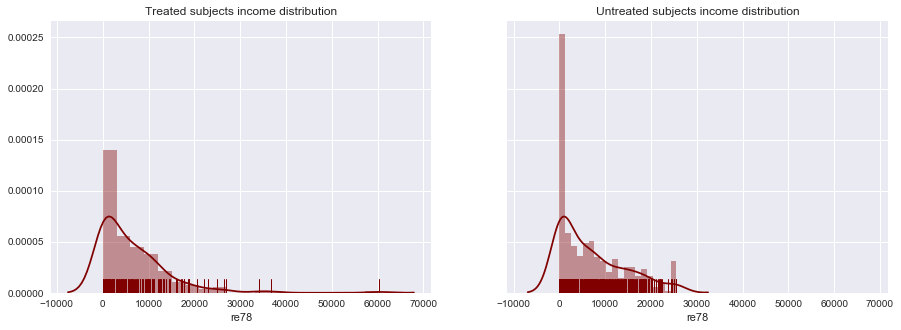

In [51]:
#Plotting the distributions of income in 1978 of the two datasets.

f, ax = plt.subplots(1, 2, sharex=True,sharey=True,figsize=(15, 5))
treated_plt=sns.distplot(treated_outcome,bins=20,rug=True,kde=True,ax=ax[0],color='maroon')
untreated_plt=sns.distplot(untreated_outcome,bins=20,rug=True,kde=True,ax=ax[1],color='maroon')

#Adding titles
treated_plt.set_title('Treated subjects income distribution')
untreated_plt.set_title('Untreated subjects income distribution')
plt.show()

From the plots, we see that : while there are some abnormally large values of income from the treated subjects (such as around 60,000), the untreated subjects seem to have very similar distribution to that of the treated subjects. 

This may suggest that the treatement had no effect on the subjects.

# 2. A closer look at the data :

In [52]:
#This function plots the distribution of a certain feature passed as a parameter amongst the treated and the control groups.
#The plots will share the same y axis .
def plot_distribution(feature,ylim,treated,untreated): 
    
    #Selecting our feature column.
    treated_feature=treated[[feature]].dropna(axis=0,how='all')
    untreated_feature=untreated[[feature]].dropna(axis=0,how='all')
    
    #Creating a new column with ones to help count when grouping.
    treated_feature['distribution']=pd.DataFrame(np.ones(len(treated_feature)))
    untreated_feature['distribution']=pd.DataFrame(np.ones(len(untreated_feature)))

    #Grouping by feature.
    treated_feature_dist=treated_feature.groupby(by=feature,as_index=True).sum().dropna()
    untreated_feature_dist=untreated_feature.groupby(by=feature,as_index=True).sum().dropna()
    
    treated_feature_dist=treated_feature_dist/len(treated_feature.dropna())
    untreated_feature_dist=untreated_feature_dist/len(untreated_feature.dropna())

    #Resetting index for plotting
    treated_feature_dist=treated_feature_dist.reset_index()
    untreated_feature_dist=untreated_feature_dist.reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    #Plotting feature distribution in control and treated groups in histograms
    treated_feature_dist.plot(ax=axes[1], x=feature, ylim=ylim,title='treated',kind='bar',color='purple')
    untreated_feature_dist.plot(ax=axes[0],x=feature,ylim=ylim,title='control',kind='bar',color='purple')
    
    plt.show()

## 2.a plotting with education level :

Our first intuition was to plot the effects of the treatement by years of education. Since we'd expect someone with more years of education to respond well to training.

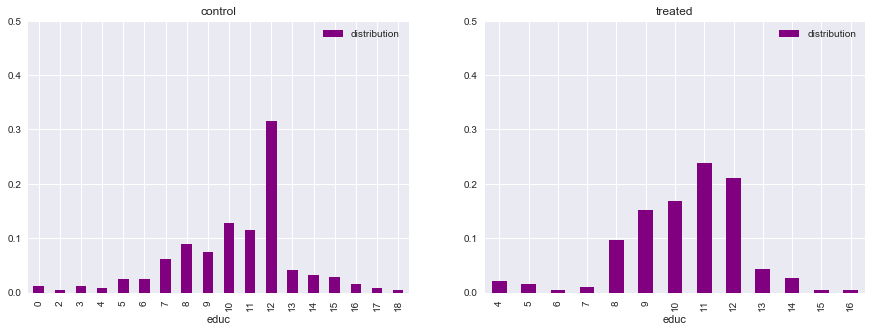

In [53]:
plot_distribution('educ',(0,0.5),treated,untreated)

Years of education distributions are very far off from each other in the two dataframes. 

The control group's years of education range from 0 to 18 while the treated group's ranges from 4 to 16. 

Also, the distribution of the common years of education are not similar.

## By hispanic : 

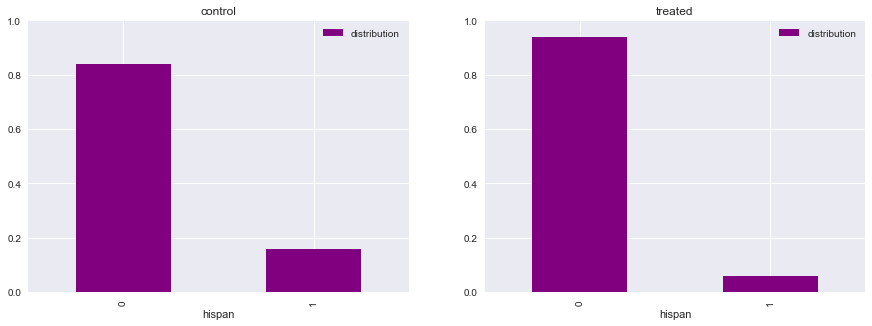

In [54]:
plot_distribution('hispan',(0,1),treated,untreated)

The number of hispanics in both groups is small, so the odd results probably wasn't caused by this feature.

## By black : 

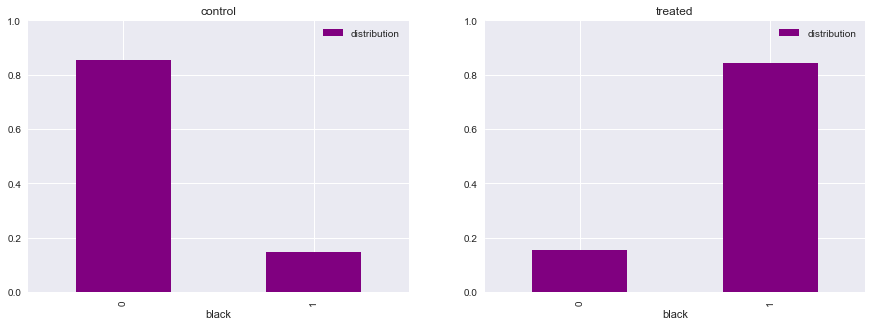

In [55]:
plot_distribution('black',(0,1),treated,untreated)

The fraction of black subjects in both groups are almost the inverse of each other.

## By marital status :

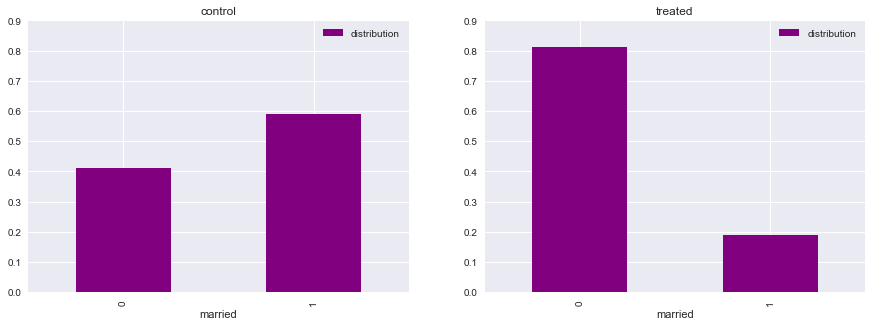

In [56]:
plot_distribution('married',(0,0.9),treated,untreated)

The marital status distributions are completely different in the two datasets. There are more married people in the control group and more single individual in the treated group.

It is logical to assume that the married individuals are more likely to have a higher income. (Or, that people with higher income are more likely to be married.)

So, this difference in distribution should dramatically affect the result. 

# Age : 

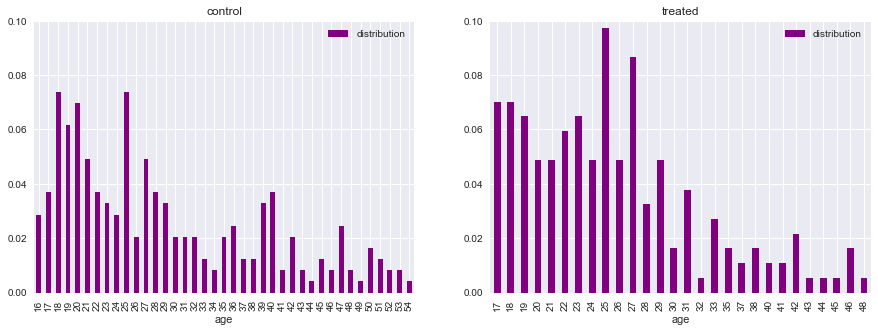

In [57]:
plot_distribution('age',(0,0.1),treated,untreated)

The ages in the control group range from 16 to 55 ,while in the treated group they range from 17 to 48. 

Also, in the treated group there more young subjects ratio (between 17 to 30) overall. 

This difference could affect the results we seek, since the older you are the more likely you are to be paid more.

## By previous incomes : 

In [58]:
#This function plots the income distribution in the year designated by the parameter "column" for the treated and control groups.

def plot_income_distribution(column,treated,untreated) : 
    #Plotting the distributions of income in 1974 and 1975 of the two datasets.

    f, ax = plt.subplots(1, 2, sharex=True,sharey=True,figsize=(15, 5))
    
    #Plotting distribution using seaborn (sns)
    treated_plt=sns.distplot(treated[column],bins=20,rug=False,kde=True,ax=ax[0],color='maroon')
    untreated_plt=sns.distplot(untreated[column],bins=20,rug=False,kde=True,ax=ax[1],color='maroon')

    #Adding titles
    treated_plt.set_title('Treated subjects income distribution in 19'+column[2:])
    untreated_plt.set_title('Control subjects income distribution in 19'+column[2:])
    plt.show()

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


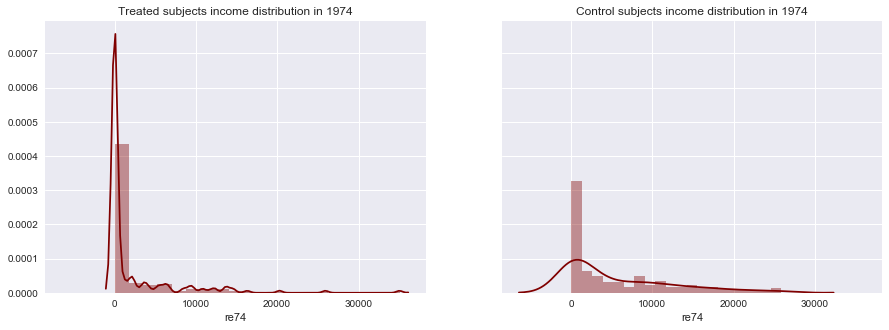

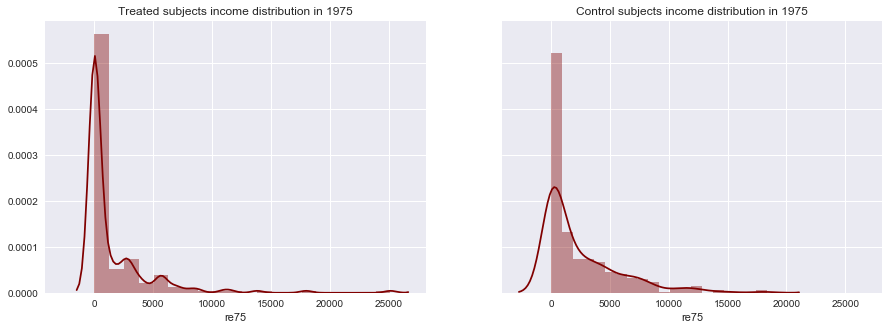

In [59]:
#Plotting income distribution in 1974 and then 1975 for treated vs control group.
plot_income_distribution('re74',treated,untreated)
plot_income_distribution('re75',treated,untreated)

We can see that the treated subjects are more concentrated in the lower end of previous incomes (e.g. between 0 and 5000) than control subjects, while the control subjects have more individual having higher previous incomes (e.g between 5000 and 10000).

It makes sense to select subjects that had low income in the previous couple of years in order to see how effective the training was. However, it is important to select a control group with similar conditions to see who performed better.

## By degree:

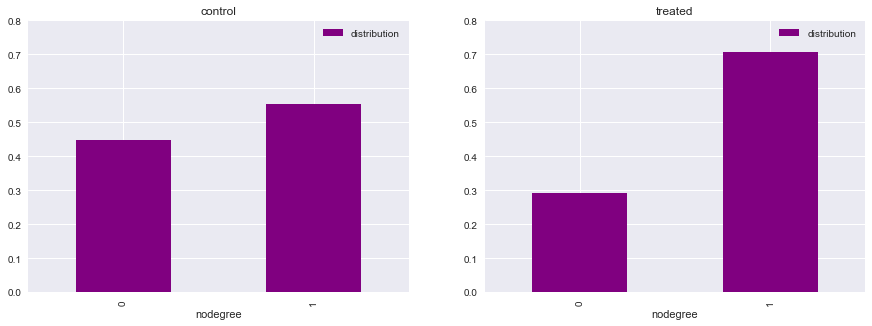

In [60]:
plot_distribution('nodegree',(0,0.8),treated,untreated)

The treated group has a larger fraction of subjects with no degree than the control group, which may explain the high income of the control group.

# 3. Propensity score model :

In [61]:
#Creating the model.
logistic = linear_model.LogisticRegression()

#Selecting the pre-treatement features.
features=['age','educ','black','hispan','married','nodegree','re74','re75']
Xt=dataset[features]
y=dataset[['treat']]['treat']

#Fitting the model
logistic.fit(Xt,y)

#Printing the coefficient of each feature.
for f in range(len(features)):
    print("{0} * {1} + ".format(logistic.coef_[0][f], features[f]))
print(logistic.intercept_[0])


-0.006794203196110479 * age + 
-0.06602229032932304 * educ + 
2.584312591779158 * black + 
-0.04066538431557746 * hispan + 
-0.8414791177767145 * married + 
-0.36073074385840437 * nodegree + 
-7.541707841613298e-05 * re74 + 
5.759219439211685e-05 * re75 + 
-0.632047454715


In [62]:
#Simple function that calculates the propensity score by using the function predict_proba of the linear model.
def calculate_score(line):

    return logistic.predict_proba([[int(line['age']),int(line['educ']),
                                    int(line['black']),int(line['hispan']),
                                    int(line['married']),int(line['nodegree']),
                                    float(line['re74']),float(line['re75'])]])[0][1]

In [63]:
#Adding the propensity scores to the dataframes. 
treated['score']=treated.apply(lambda x : calculate_score(x),axis=1)
untreated['score']=untreated.apply(lambda x : calculate_score(x),axis=1)

In [64]:
#Showing the subjects of the treated group with their features and propensity score.
treated.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.700118
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.731792
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0.656531
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0.678402
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,0.076562


In [65]:
#Showing the subjects of the control group with their features and propensity score.
untreated.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
185,PSID1,0,30,12,0,0,1,0,20166.730,18347.23,25564.67,0.050504
186,PSID2,0,26,12,0,0,1,0,25862.320,17806.55,25564.67,0.033330
187,PSID3,0,25,16,0,0,1,0,25862.320,15316.21,25564.67,0.022574
188,PSID4,0,42,11,0,0,1,1,21787.050,14265.29,15491.01,0.024906
189,PSID5,0,25,9,1,0,1,1,14829.690,13776.53,0.00,0.416054
190,PSID6,0,37,9,1,0,1,1,13685.480,12756.05,17833.20,0.402995
191,PSID7,0,32,12,0,0,1,0,19067.580,12625.35,14146.28,0.039388
192,PSID8,0,20,12,1,0,0,0,7392.314,12396.19,17765.23,0.765043
193,PSID9,0,38,9,0,1,1,1,16826.180,12029.18,0.00,0.035451
194,PSID10,0,39,10,0,0,1,1,16767.410,12022.02,4433.18,0.034502


# 4. Balancing the datasets via matching : 

In [66]:
#This function manually finds a match between the two dataframes
def find_match(df1,df2): 
    
    matches=[]
    
    #Going through the first dataframe's elements
    for i in range(len(df1)) : 
        
        #Extracting the score of the subject at index i and putting it as an array of length df2.
        score_array=[df1.at[i,'score'] for j in range(len(df2))]
        
        #Computing the difference between each score at df2 and the score at index i of df1
        df2['difference']=np.abs(df2['score']-score_array)
        
        #Sorting the value in ascending order.
        minimums=sorted(df2['difference'])
        
        #Take the smallest difference by default
        j=0
        match=list(df2['difference']).index(minimums[0])
        #Ensure uniqueness of matches, if a match found for index i is already used go to the second smallest element of minimums and so on...
        while(match in matches) : 
            j+=1
            match=int(list(df2['difference']).index(minimums[j]))
            
        #Keeping track of used elements of df2 as matches
        matches.append(match)
        
        #Adding the match index to df1.
        df1.at[i,'match']=int(match)
    

Here we find matches with the find_match function defined above, and we extract the dataframe that should match the treated group's data.

In [67]:
#Resetting index for correct indexing.
untreated=untreated.reset_index(drop=True)

#Finding match
find_match(treated,untreated)

#Casting matches indices to column added by the find_match function int for indexing.
treated['match']=treated['match'].apply(lambda x : int(x))

#Extracting the matched dataframe with the list of match indices.
matched=untreated.loc[list(treated['match'])]

#Deleting no longer used column
del untreated['difference']
del treated['match']

In the rest of this section, we will show the new plots as done in second part with the new matched dataframe and discuss what we see.

## By age: 

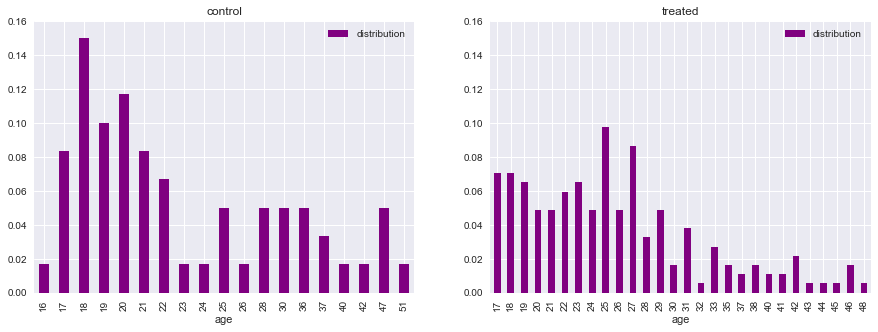

In [68]:
plot_distribution('age',(0,0.16),treated,matched)

The distributions of ages is much closer here. The two plots have more subject among the younger generation (between 16 and 30)

## By education : 

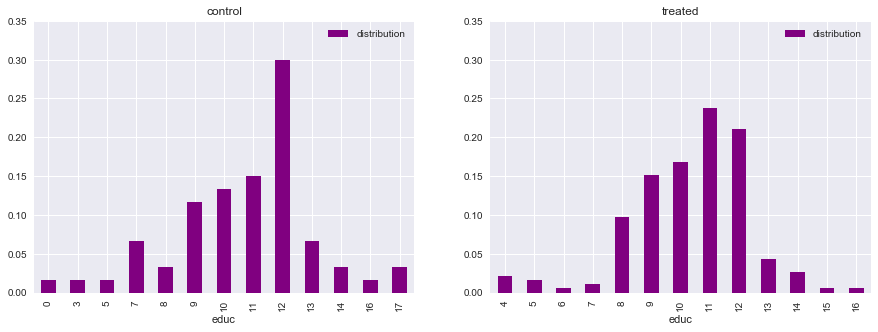

In [69]:
plot_distribution('educ',(0,0.35),treated,matched)

The distributions of the years of education are very similar, unlike what was previously shown.

However, having different values in both plots makes it a little hard to see.

## By hispanic:

In [ ]:
plot_distribution('hispan',(0,1),treated,matched)

## By black:

In [ ]:
plot_distribution('black',(0,1),treated,matched)

## Previous income : 

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


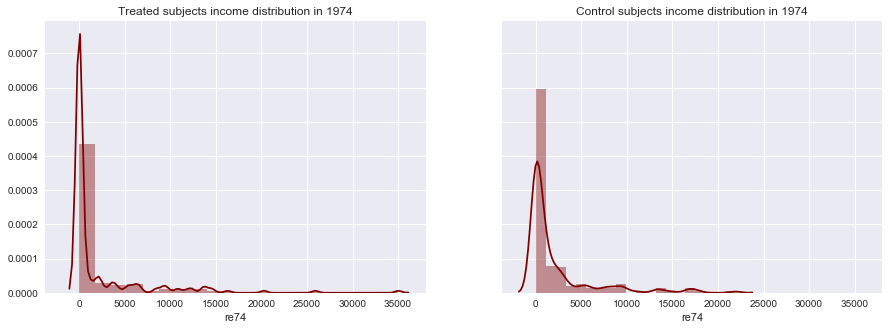

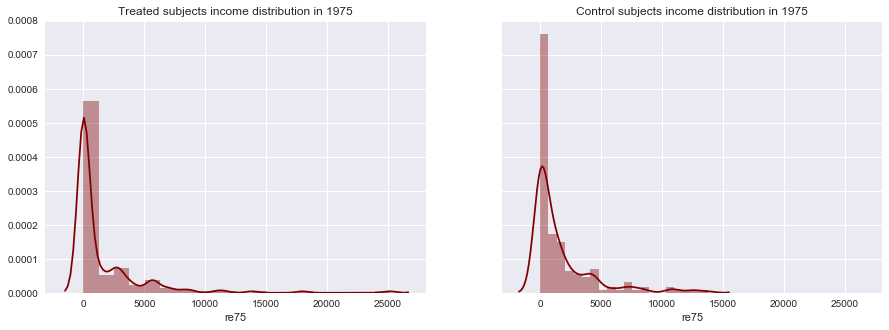

In [72]:
plot_income_distribution('re74',treated,matched)
plot_income_distribution('re75',treated,matched)

The distribution plots are somewhat more similar than with the entire control dataset vs treated group.

Which indicates that the matching has worked, though not perfectly.

# 5. Further matching : 

The values of the features selected still do not match. For instance, in the matched dataframe we have in the 'educ' column values of 0, 3 and 17 which we do not have in the treated subjects. And that makes it hard to make good comparisons.

So we will start by filtering the untreated subject table to match the feature values existing in the treated group.

To do so, we will start by implementing the function below.

In [73]:
#This function finds the list of values for each feature and filters out any rows in the untreated 
#dataframe that have values not contained in the list.
def filter_features(treated,untreated,features) :
    matching=untreated.dropna(axis=0,how='all').copy()
    #Iterating over features
    for feature in features : 
        #Extracting values for current feature.
        values= np.unique(list(treated[feature]))
        
        
        indices=[]
        matching=matching.reset_index(drop=True)
        
        
        for i in range(len(matching)) : 
            if(matching.at[i,feature] not in values) : 
                #Append index to indices if feature of row i is not in values
                indices.append(i)
        #Dropping the indices in the list "indices"
    matching=matching.drop(indices)
    matching=matching.reset_index(drop=True)
    return matching

Then we will drop all abnormal columns values that we see from the distribution graph of previous incomes.

We will do that by dropping rows that contain incomes above a certain threshold.

To do that, we will use the function defined below.

In [74]:
#This function drop rows that contain abnormally large previous incomes.
def filter_incomes(column,df,thres) : 
    
    indices=[]
    df=df.reset_index(drop=True)
    for i in range(len(df)) : 
        #Testing if income is larger than certain threshold
        if(df.at[i,column] > thres) : 
            indices.append(i)
    #Dropping rows in indices
    df=df.drop(indices)
    df.reset_index(drop=True)
    return df

In [75]:
#Filtering out the oddly large incomes in 1974 and 1975 for the control group
untreated=filter_incomes('re74',untreated,15000)
untreated=filter_incomes('re75',untreated,15000)

treated=filter_incomes('re74',treated,15000)
treated=filter_incomes('re75',treated,15000)

untreated=filter_features(treated,untreated,['age','educ'])


untreated['score']=untreated.apply(lambda x : calculate_score(x),axis=1)

In [76]:
find_match(treated,untreated)
treated['match']=treated['match'].apply(lambda x : int(x))

new_matched=untreated.loc[list(treated['match'])]

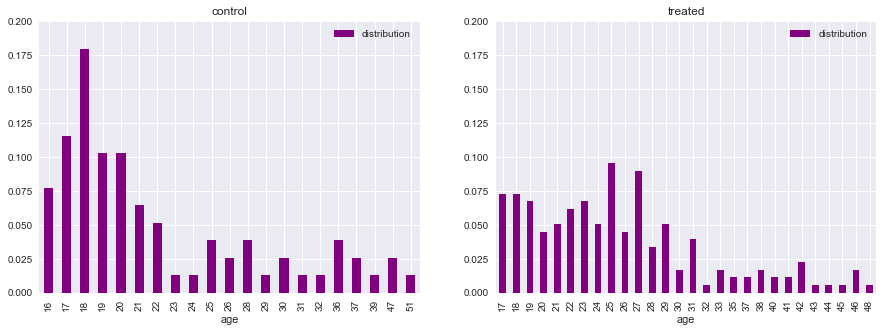

In [77]:
plot_distribution('age',(0,0.2),treated,new_matched)

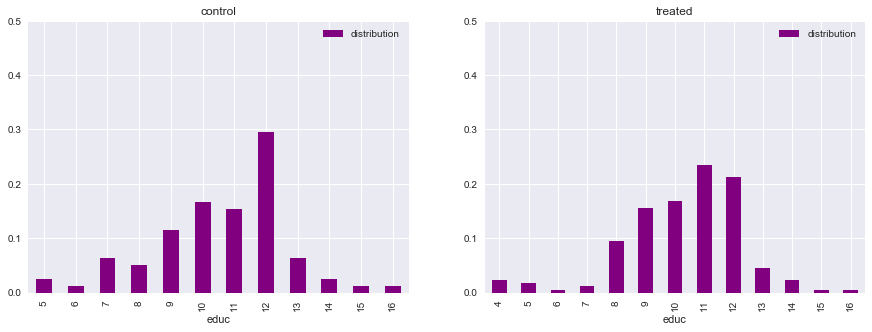

In [78]:
plot_distribution('educ',(0,0.5),treated,new_matched)

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


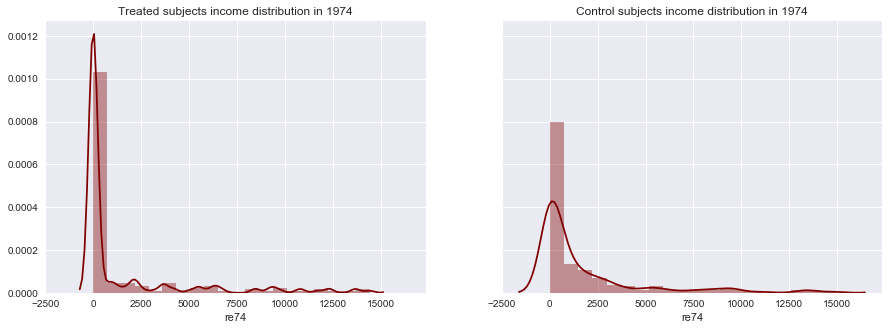

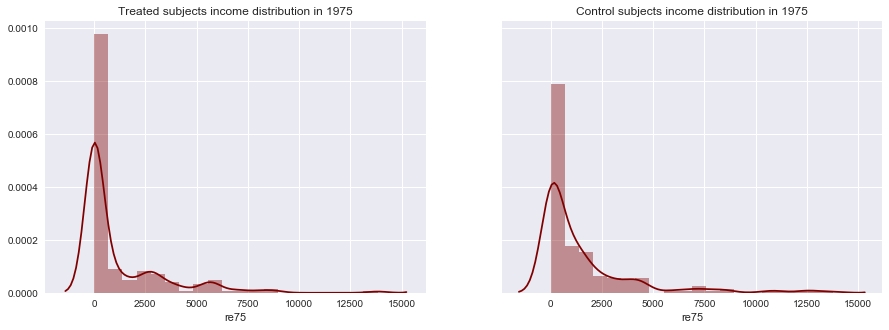

In [79]:
plot_income_distribution('re74',treated,new_matched)
plot_income_distribution('re75',treated,new_matched)

The distribution in the treated and the control group look similar in both previous income years.

# 6. A less naive analysis:

In [80]:
new_matched[['age','educ','married','re74','re75','re78']].describe()[1:]

,age,educ,married,re74,re75,re78
mean,23.413408,10.396648,0.150838,1724.132895,1551.029435,5438.595111
std,9.405774,2.380678,0.358895,3007.544607,2551.652813,5799.427323
min,16.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,9.000000,0.000000,0.000000,0.000000,74.625190
50%,19.000000,11.000000,0.000000,391.853400,485.177400,3406.160000
75%,25.000000,12.000000,0.000000,1928.898000,1855.669000,8527.221000
max,55.000000,16.000000,1.000000,14829.690000,13776.530000,20243.380000


In [81]:
treated[['age','educ','married','re74','re75','re78']].describe()[1:]

,age,educ,married,re74,re75,re78
mean,25.720670,10.324022,0.173184,1462.123086,1170.726095,6181.045887
std,7.187705,2.012889,0.379468,3217.106256,2171.594630,7617.908198
min,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,0.000000,0.000000,0.000000,144.894950
50%,25.000000,11.000000,0.000000,0.000000,0.000000,4232.309000
75%,28.500000,12.000000,0.000000,841.321450,1682.360000,9620.770000
max,48.000000,16.000000,1.000000,14426.790000,13830.640000,60307.930000


From the matched control subjects, we see that the training had a significant effect on the trained subject, since the mean is higher and with bigger standard deviation.

The median is also higher, as well as all the quartiles.


To sum up, the treated subjects are better in every way than the matched control group. Which helps the case of proving the effectiveness of the training.

# II. Applied ML : 

In [82]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import random
import math

# 1.

Here, we load the dataset and its corresponding categories. Then, we fit the data in a tfidf vectorizer while using the option stop_words='english' to remove the stop words, in order to increase the overall accuracy.

In [83]:
#Loading the dataset.
newsgroups = fetch_20newsgroups(subset='all')

#Constructing the tf-idf matrix after removing the stop words, to increase precision.
vectorizer=TfidfVectorizer(stop_words='english')
tf_idf=vectorizer.fit_transform(newsgroups.data)

#loading the categoy indices
categories=newsgroups.target

#loading the category names
names=np.array(newsgroups.target_names)


Here, we separate the entire matrix into validation set, test set and train set.

In [84]:
#Extracting the number of documents
n_docs=(tf_idf).shape[0]

#Selecting the validation indices randomly by choosing 10% of the number of documents of indices.
validation_idx=random.sample(range(0,n_docs),math.floor(0.1*n_docs))
#Extracting matching label indices.
y_val=categories[validation_idx]
#deleting the validation indices for later random selection.
remaining = np.delete(range(0,n_docs), validation_idx)

#Selecting the indices of the training set by choosing randomly 80% of the number of documents of indices.
training_idx=random.sample(set(remaining),math.floor(0.8*n_docs))
#Extracting matching label indices.
y_train=categories[training_idx]
#deleting the train indices for later random selection.
remaining = np.delete(range(0,n_docs), training_idx+validation_idx)

#test indices take the remaining indices
test_idx=remaining
y_test=categories[test_idx]

#----Extracting actual train, validation and test sets and their corresponding labels.----#

#Extracting X_train and Y_train
X_train=tf_idf[training_idx]
y_train=names[y_train]

#Extracting X_val and Y_val
X_val=tf_idf[validation_idx]
y_val=names[y_val]

#Extracting X_test and Y_test
X_test=tf_idf[test_idx]
y_test=names[y_test]

In [88]:
#Making sure that the sets are distinct.
assert(len(np.intersect1d(np.intersect1d(validation_idx,test_idx),training_idx))==0)

#Making sure that the sets sum up to the entire tf-idf matrix
assert(len(np.union1d(np.union1d(validation_idx,test_idx),training_idx))==n_docs)

## 2. 

Below, we will perform a grid search to find the best values of n_estimators and max_depth.

We will do so by calling a function that we implemented (grid_search) : which iterates over values of n_estimators and max_depths and returns the best ones.

### Grid Search : 

In [93]:
#This function does a grid search on the lists passed as parameters as n_estimators and max_depths
#And returns the parameters that maximize the accuracy_score.
def grid_search(n_estimators,max_depths):
    max_accuracy=0.0
    best_n_estimators=0
    best_max_depth=0
    #Iterating over n_estimators
    for i in n_estimators:
        #Iterator over max_depths
        for j in max_depths:
            max_accuracy=0.0
            
            #Building model
            classifier = RandomForestClassifier(n_estimators=i,max_depth=j)
            #Fitting
            classifier.fit(X_train,y_train)
            #Calculating accuracy with validation set.
            curr_accuracy=accuracy_score(y_val,classifier.predict(X_val))
            
            #Testing if the accuracy is the best so far.
            if(curr_accuracy>max_accuracy):
                best_classifier=classifier
                max_accuracy=curr_accuracy
                best_n_estimators=i
                best_max_depth=j
    print("From the lists provided as paramaters, the best n_estimators value is "+str(best_n_estimators)+" The best max_depth is "+str(best_max_depth)+" which gives us an accuracy of "+str(max_accuracy))
    return max_accuracy,best_n_estimators,best_max_depth,best_classifier

In [94]:
#Warning : Do not run this cell unless you have an hour to kill.


n_estimators=[50,100,500,1000]
max_depths=[30,50,80,100]
max_accuracy,n_estimators,max_depth,classifier=grid_search(n_estimators,max_depths)

From the lists provided as paramaters, the best n_estimators value is 1000 The best max_depth is 100 which gives us an accuracy of 0.870488322718


After playing with the values a bit, we see that the more we increase the n_estimators, the better the accuracy gets. 

The same can be said about the max_depth parameter. However, in order to avoid overfitting the model, we didn't go too crazy with how large the max_depth is.

So finally, Choosing a n_estimator value of 1000 and max_depth of 100 was sufficient to get a high accuracy of around 87%. 

However, going any higher than 1000 and 100 will just take too long to run for very little improvement.

After getting our best parameters and best classifier we will take a look at the confusion matrix. 

### Confusion matrix : 

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/firasbenothman/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


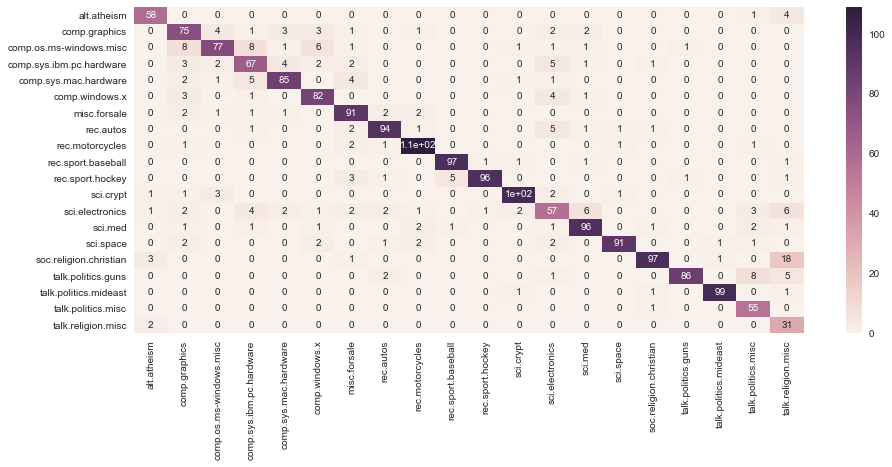

In [100]:
matrix = confusion_matrix(classifier.predict(X_test),y_test)

plt.figure(figsize=(15,6))
sns.heatmap(matrix, annot=True ,xticklabels=names,yticklabels=names)

The confusion matrix has a lot of zeros and very small values anywhere other than the diagonal.
This means that a lot of values were predicted correctly (87%).

The diagonal values represent the number of correctly predicted categories of a category at that index.

There seems to be a lot of mispredictions between category :
- 'comp.graphics'(index 1 ), 'comp.os.ms-windows.misc'(index 2)
- 'talk.politics.misc' (index 18) and 'talk.politics.guns' (index 16) 
- 'talk.religion.misc' (index 19) and'soc.religion.christian' (index 15). 
- 'comp.sys.ibm.pc.hardware' (index 3) and 'comp.os.ms-windows.misc' (index 2)

That makes sense since the topics confused should be very similar in terms of terms contained in text.

Almost all the rest of the confusion have very small occurences (between 0 and 6).

In [101]:
feature_importance=classifier.feature_importances_

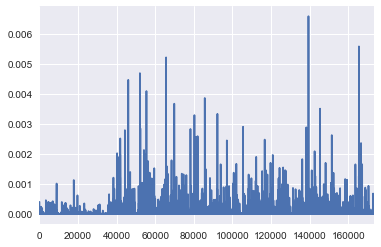

In [105]:
#Plotting to see how different the values are.
pd.Series(feature_importance).plot()

From the graph, we see that all the features have small importance factor. 

However, very few features have importance factor above 0.003 and even fewer above 0.004, while the majority of the rest of the features have values below 0.002 and even 0.001.

which means some features are more important than most other features.

In [119]:
#Extracting most important features. The threshold chosen for this is 0.003.
most_important=feature_importance[feature_importance>0.003]
important_indices=[list(feature_importance).index(i) for i in most_important]
'The number of features with importance factors above 0.003 is '+ str(len(most_important)) +' and their indices in the tf-idf matrix are '+str(important_indices)

'The number of features with importance factors above 0.003 is 11 and their indices in the tf-idf matrix are [46012, 52042, 55427, 65617, 69845, 80282, 85645, 92197, 139367, 145386, 165511]'

The vast difference between the importance factors shows that we could re-run the same steps with many less terms, which will definately take much less time to compute and the precision should not drop too much after doing that.